## import original define of BasketOptionPricer Class

In [1]:
from math import sqrt, log, exp
from scipy.stats import norm
import numpy as np
import pandas as pd
   
   

class BasketOptionPricer:
    def __init__(self, S1,S2, K, T, sigma1,sigma2, r, rho, option_type):
        self.S1 = S1        # Initial stock price of asset1
        self.S2 = S2        # Initial stock price of asset2
        self.K = K          # Strike price of the option
        self.T = T          # Time to maturity of the option
        self.sigma1=sigma1  # Volatility of the asset1
        self.sigma2=sigma2  # Volatility of the asset2
        self.r = r          # Risk-free interest rate
        self.rho = rho      # Correlation matrix or scalar
        self.option_type = option_type  # 'call' or 'put'


    #another two parameters below: M and control_variate will be used  in arithmetic_basket method and will not defined here

    def geometric_basket(self):
        n = 2  # Number of assets in basket
        B = (self.S1 * self.S2) ** (1 / n)  # Geometric Mean of Assets

        # Creating the covariance matrix
        sigma = [self.sigma1, self.sigma2]

        # Calculating basket volatility using the covariance matrix
        sigma_b = sqrt(self.sigma1**2 + self.sigma2**2 + 2 * self.rho * self.sigma1 * self.sigma2)/n

        # Adjusted drift term
        mu_b = self.r - 0.5 * sum(sigma[i] ** 2 for i in range(n)) / n + 0.5 * sigma_b ** 2

        # Black-Scholes d1 and d2 parameters
        d1 = (log(B / self.K) + (mu_b + 0.5 * sigma_b ** 2) * self.T) / (sigma_b * sqrt(self.T))
        d2 = d1 - sigma_b * sqrt(self.T)

        # Calculating option price based on option type
        if self.option_type == 'call':
            price = exp(-self.r * self.T) * (B * exp(mu_b * self.T) * norm.cdf(d1) - self.K * norm.cdf(d2))
        else:
            price = exp(-self.r * self.T) * (self.K * norm.cdf(-d2) - B * exp(mu_b * self.T) * norm.cdf(-d1))

        return {'geometric_price': price}




    def price_path(self,M):
        np.random.seed(100)#Fixing the seed for reproducibility
        
        #Drift parameter of Brownian motion
        drift1 = (self.r- 0.5 *self.sigma1**2)*self.T 
        drift2 = (self.r- 0.5 *self.sigma2**2)*self.T 

        #Volatility parameter of Brownian motion
        vol1 = self.sigma1 * np.sqrt(self.T) 
        vol2 = self.sigma2 * np.sqrt(self.T) 

        #generate standard normal random variables with correlarion rho
        Z1 = np.random.randn(M,1)
        Z2 = Z1*self.rho+np.sqrt(1-self.rho**2)*np.random.randn(M,1)


        #generate price path
        S1Path = self.S1* np.exp(drift1 + (vol1*Z1)) 
        S2Path = self.S2* np.exp(drift2 + (vol2*Z2)) 
        return S1Path,S2Path
    

    def arithmetic_basket(self,M,control_variate):
        """
        Prices an arithmetic basket option using Monte Carlo simulation,
        with optional control variate technique.
        """
        S1Path, S2Path = self.price_path(M)
        
        # Calculate arithmetic basket option payoff
        if self.option_type == 'call':
            arithPayoff = np.exp(-self.r * self.T) * np.maximum((S1Path + S2Path) / 2  - self.K, 0)
            geoPayoff=np.exp(-self.r * self.T)* np.maximum(np.sqrt(S1Path * S2Path)- self.K,0)
        else:
            arithPayoff = np.exp(-self.r * self.T) * np.maximum(self.K -(S1Path + S2Path) / 2 , 0)
            geoPayoff=np.exp(-self.r * self.T)* np.maximum(self.K-np.sqrt(S1Path * S2Path),0)

        # Standard Monte Carlo without control variate
        if not control_variate:
            Pmean = np.mean(arithPayoff)
            Pstd = np.std(arithPayoff)
            confmc = [Pmean - 1.96 * Pstd / np.sqrt(M), Pmean + 1.96 * Pstd / np.sqrt(M)]
            return {'arithmetic_price': Pmean, 'confidence_interval': confmc}

        # Control variate using geometric basket price
        else:
            geoPrice = self.geometric_basket()['geometric_price']  # Closed form solution for geometric basket
            # Covariance and variance for the control variate technique
            covXY = np.mean(np.multiply(arithPayoff,geoPayoff))- np.mean(arithPayoff)*np.mean(geoPayoff) 
            theta = covXY / np.var(geoPayoff)
            Z = arithPayoff + theta * (geoPrice - geoPayoff)
            Zmean = np.mean(Z)
            Zstd = np.std(Z)
            confcv = [Zmean - 1.96 * Zstd / np.sqrt(M), Zmean + 1.96 * Zstd / np.sqrt(M)]
            return {'arithmetic_price': Zmean, 'confidence_interval': confcv}




## use inheritance to implement analysis.As we can see,s1/s2,sigma1,sigma2 has Symmetry,so we only need to analyze one 

First,geometric Basket option

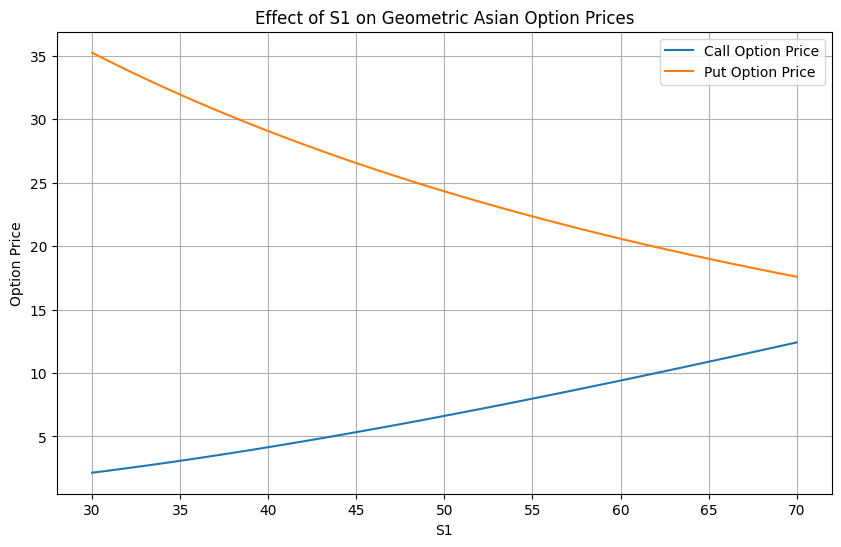

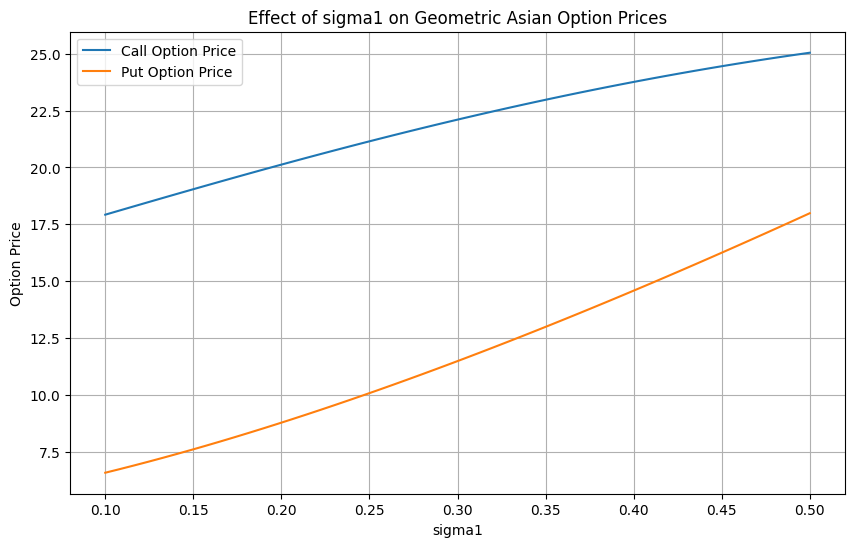

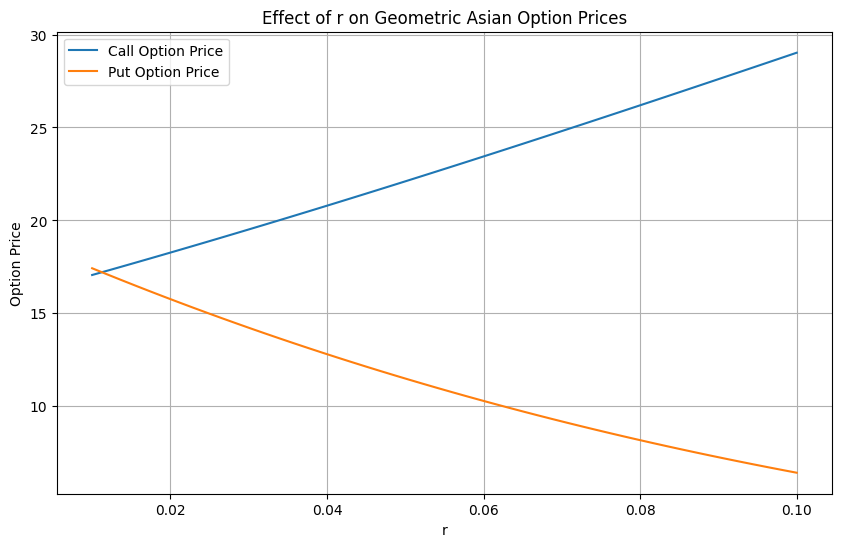

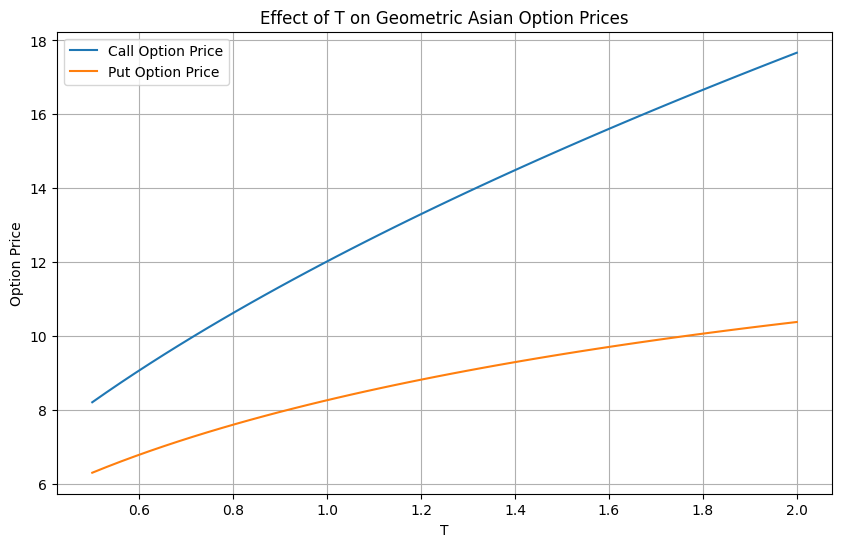

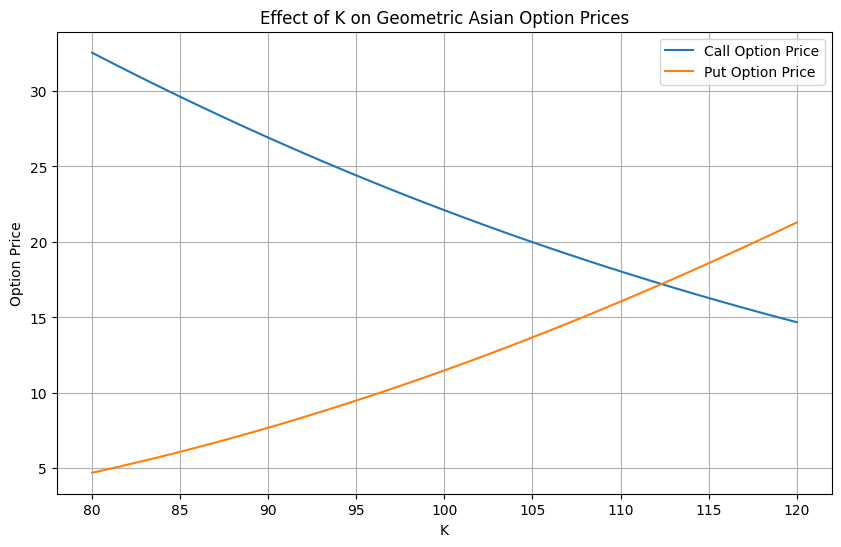

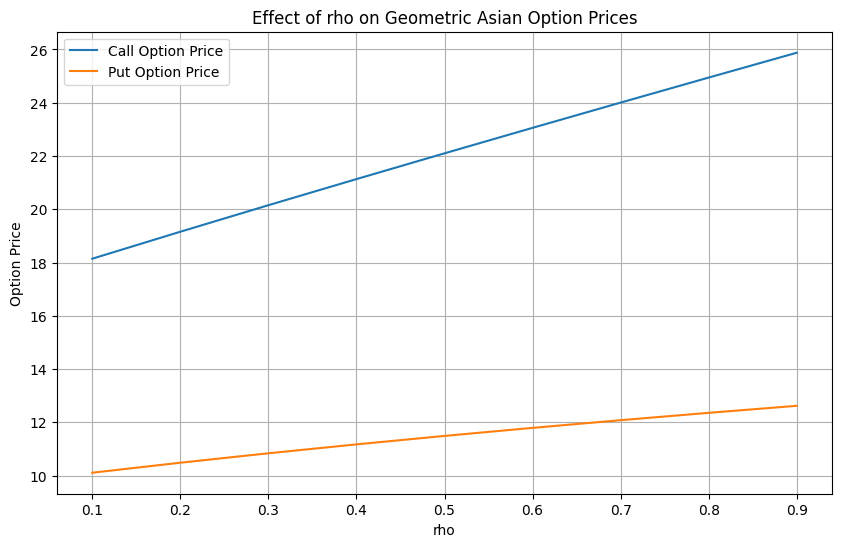

In [5]:
import matplotlib.pyplot as plt


class GeometricAsianOptionAnalysis(BasketOptionPricer):
    def analyze_effect(self, M, factor_name, factor_range):
        call_prices = []
        put_prices = []
        original_value = getattr(self, factor_name)

        for factor_value in factor_range:
            setattr(self, factor_name, factor_value)
            
            self.option_type = 'call'
            call_price = self.geometric_basket()['geometric_price']
            call_prices.append(call_price)

            self.option_type = 'put'
            put_price = self.geometric_basket()['geometric_price']
            put_prices.append(put_price)

        setattr(self, factor_name, original_value)  # Restore the original factor value

        plt.figure(figsize=(10, 6))
        plt.plot(factor_range, call_prices, label='Call Option Price')
        plt.plot(factor_range, put_prices, label='Put Option Price')
        plt.title(f'Effect of {factor_name} on Geometric Asian Option Prices')
        plt.xlabel(factor_name)
        plt.ylabel('Option Price')
        plt.grid(True)
        plt.legend()

        # Save the plot to a file
        plt.savefig(f"{factor_name}_effect_on_Geometric_Asian_Option_Prices.png")
        plt.show()
# Initialize the option pricer instance
pricer =GeometricAsianOptionAnalysis(S1=100,S2=100, K=100, T=3, sigma1=0.3,sigma2=0.3, r=0.05, rho=0.5,option_type='call')

# Analyze the effect of initial stock price (S1/S2) on the option price
pricer.analyze_effect(M=10000, factor_name='S1', factor_range=np.linspace(30, 70, 50))

# Analyze the effect of volatility (sigma1/sifma2) on the option price
pricer.analyze_effect(M=10000, factor_name='sigma1', factor_range=np.linspace(0.1, 0.5, 50))

# Analyze the effect of risk-free interest rate (r) on the option price
pricer.analyze_effect(M=10000, factor_name='r', factor_range=np.linspace(0.01, 0.1, 50))

# Analyze the effect of time to maturity (T) on the option price
pricer.analyze_effect(M=10000, factor_name='T', factor_range=np.linspace(0.5, 2, 50))

# Analyze the effect of strike price (K) on the option price
pricer.analyze_effect(M=10000, factor_name='K', factor_range=np.linspace(80, 120, 50))

# Analyze the effect of number of observation points (n) on the option price
pricer.analyze_effect(M=10000, factor_name='rho', factor_range=np.arange(0.1, 1, 0.1))


## Next,Arithmetic_BasketOptionAnalysis

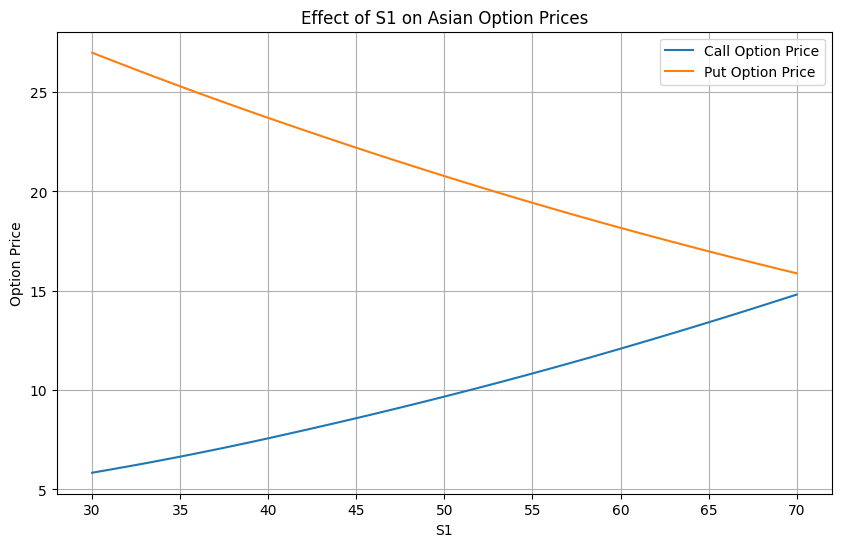

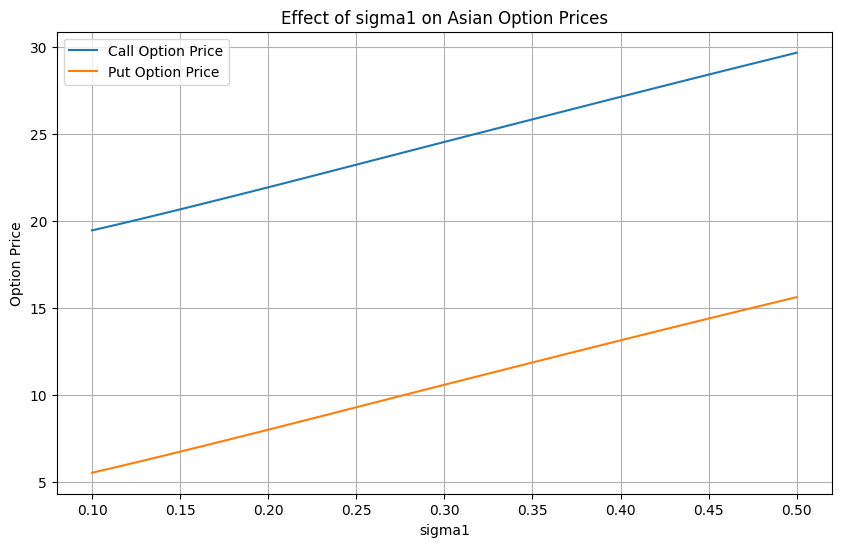

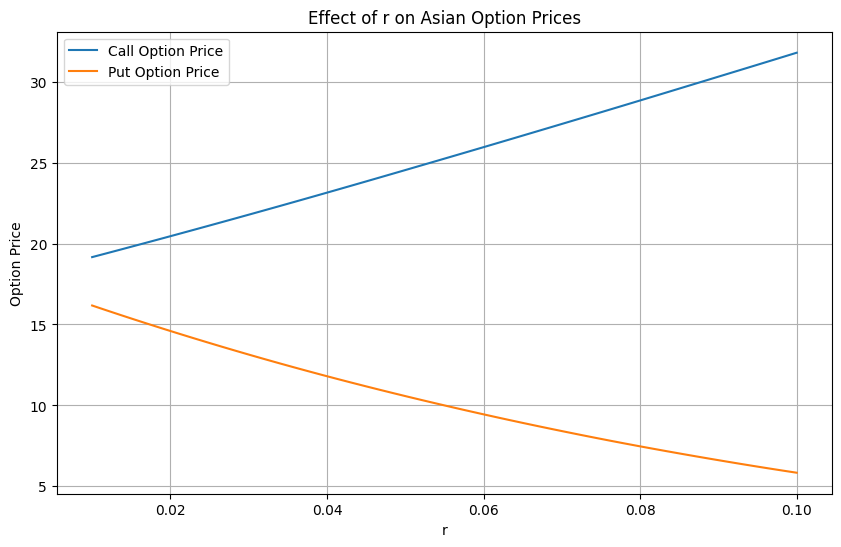

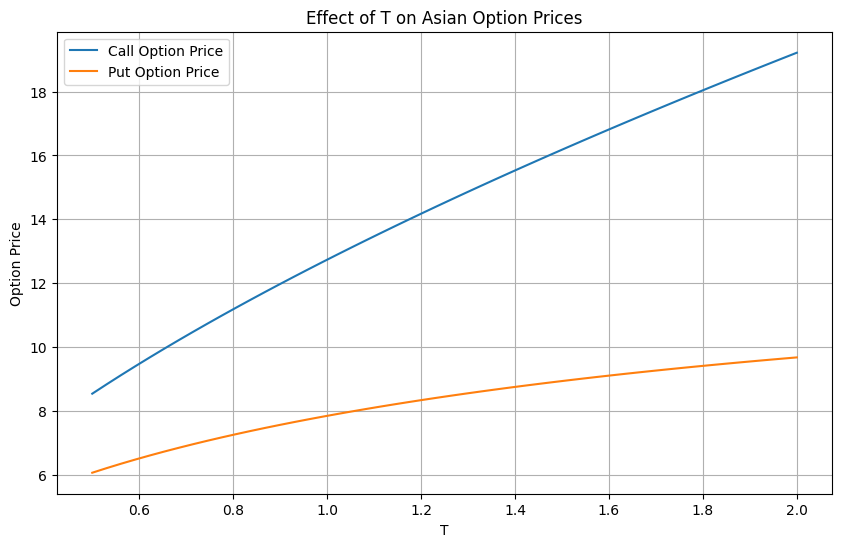

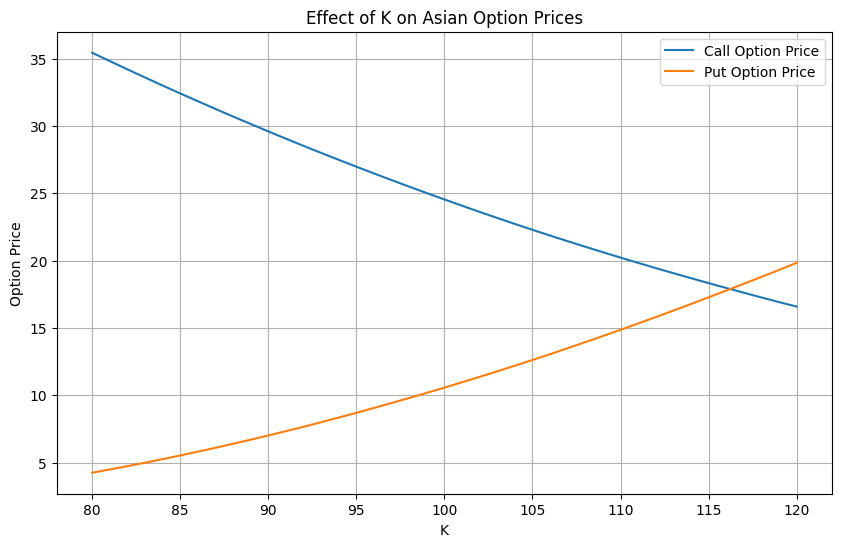

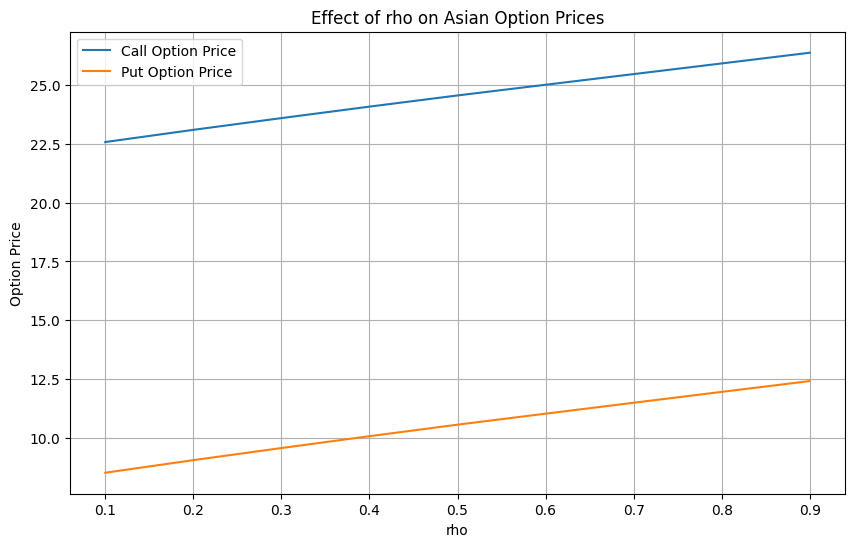

In [6]:

class Arithmetic_BasketOptionAnalysis(BasketOptionPricer):
    def analyze_effect(self, M, factor_name, factor_range):
        call_prices = []
        put_prices = []
        original_value = getattr(self, factor_name)

        for factor_value in factor_range:
            setattr(self, factor_name, factor_value)
            self.option_type = 'call'
            call_price = self.arithmetic_basket(M,control_variate=True)['arithmetic_price']
            call_prices.append(call_price)

            self.option_type = 'put'
            put_price = self.arithmetic_basket(M,control_variate=True)['arithmetic_price']
            put_prices.append(put_price)

        setattr(self, factor_name, original_value)

        plt.figure(figsize=(10, 6))
        plt.plot(factor_range, call_prices, label='Call Option Price')
        plt.plot(factor_range, put_prices, label='Put Option Price')
        plt.title(f'Effect of {factor_name} on Asian Option Prices')
        plt.xlabel(factor_name)
        plt.ylabel('Option Price')
        plt.grid(True)
        plt.legend()

        # Save the plot to a file
        plt.savefig(f"{factor_name}_effect_on_ArithmeticBasket_Option_Prices.png")
        plt.show()

# Initialize the option pricer instance
pricer =Arithmetic_BasketOptionAnalysis(S1=100,S2=100, K=100, T=3, sigma1=0.3,sigma2=0.3, r=0.05, rho=0.5,option_type='call')

# Analyze the effect of initial stock price (S1/S2) on the option price
pricer.analyze_effect(M=10000, factor_name='S1', factor_range=np.linspace(30, 70, 50))

# Analyze the effect of volatility (sigma1/sifma2) on the option price
pricer.analyze_effect(M=10000, factor_name='sigma1', factor_range=np.linspace(0.1, 0.5, 50))

# Analyze the effect of risk-free interest rate (r) on the option price
pricer.analyze_effect(M=10000, factor_name='r', factor_range=np.linspace(0.01, 0.1, 50))

# Analyze the effect of time to maturity (T) on the option price
pricer.analyze_effect(M=10000, factor_name='T', factor_range=np.linspace(0.5, 2, 50))

# Analyze the effect of strike price (K) on the option price
pricer.analyze_effect(M=10000, factor_name='K', factor_range=np.linspace(80, 120, 50))

# Analyze the effect of number of observation points (n) on the option price
pricer.analyze_effect(M=10000, factor_name='rho', factor_range=np.arange(0.1, 1, 0.1))
